<a href="https://colab.research.google.com/github/matthiasdialpad/pCSAT/blob/master/csatXLNet_768_ex3_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Make sure to mount GPU. Go to Runtime > Change Runtime Type > Select GPU option from dropdown
!nvidia-smi

Sat Aug 15 18:20:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import csv
import json
import pandas as pd
import numpy as np
import string
import torch
from torch.utils.data import TensorDataset
from keras.preprocessing.sequence import pad_sequences
from tqdm import notebook
import itertools
import seaborn as sns
from google.cloud import bigquery
from google.cloud import storage
from datetime import date
from google.colab import files, auth, drive
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
auth.authenticate_user()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!pip install transformers

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 890kB 15.3MB/s 
     |████████████████████████████████| 3.0MB 18.7MB/s 
     |████████████████████████████████| 1.1MB 44.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=683e47036219dd7e01bcb8ac22767cf5a48a0a719bcb3be0bcd08784df2aedf9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
from transformers import XLNetTokenizer

In [8]:
drive.mount('/content/gdrive')
df= pd.read_csv('gdrive/My Drive/csat_final.csv',index_col=0)

# project_id = 'talkiq-data'
# client = bigquery.Client(project=project_id)

# query = """
#   SELECT 
#     call_id,
#     response_value,
#     text
#   FROM `talkiq-data.ai_research.csat_prediction`
# """

# df = client.query(query).to_dataframe()  
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,call_id,response_value,final_utterance,duration,text_length,bert_tokenizer_length,text,bert_tokenizer_length_no_punc
0,4503600102440960,1.0,"this is daniel. how can i help? yes, no madam....",740.589,515,698,this is daniel how can i help yes no madam b...,543
1,4503602697142272,0.0,"for jacob speaking. how can i help you? hi, ho...",71.019,109,146,for jacob speaking how can i help you hi how y...,112
2,4503732200472576,1.0,"thank you for calling the street, this is aman...",237.557,217,279,thank you for calling the street this is amand...,229
3,4503877562466304,1.0,"help you today? yes, i'm just calling to confi...",265.920,588,753,help you today yes im just calling to confirm ...,616
4,4503914235691008,1.0,"solution federal i'm an offer innovations, chr...",351.710,695,912,solution federal im an offer innovations chris...,721


In [9]:
#We make the label the minority class as positive and label the majority class as negative.
minority_as_positive = {0: 1, 1: 0}
df.response_value.replace(minority_as_positive, inplace=True)

# We tokenize the texts using XLNet's Tokenizer to get the total token length of each record
# Load the XLNet tokenizer.
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
df['xlnet_tokenizer_length_no_punc'] = df.text.apply(lambda x: len(tokenizer.tokenize(x)))

In [10]:
df.head()

,call_id,response_value,final_utterance,duration,text_length,bert_tokenizer_length,text,bert_tokenizer_length_no_punc,xlnet_tokenizer_length_no_punc
0,4503600102440960,0.0,"this is daniel. how can i help? yes, no madam....",740.589,515,698,this is daniel how can i help yes no madam b...,543,575
1,4503602697142272,1.0,"for jacob speaking. how can i help you? hi, ho...",71.019,109,146,for jacob speaking how can i help you hi how y...,112,126
2,4503732200472576,0.0,"thank you for calling the street, this is aman...",237.557,217,279,thank you for calling the street this is amand...,229,246
3,4503877562466304,0.0,"help you today? yes, i'm just calling to confi...",265.920,588,753,help you today yes im just calling to confirm ...,616,638
4,4503914235691008,0.0,"solution federal i'm an offer innovations, chr...",351.710,695,912,solution federal im an offer innovations chris...,721,771


### Checking Class Distribution



In [12]:
#12.9% = minority class
df.groupby(['response_value'])['call_id'].nunique()[1] / (df.groupby(['response_value'])['call_id'].nunique()[0] + df.groupby(['response_value'])['call_id'].nunique()[1])

0.12903699893448947

In [13]:
text = df.text.values
label = df.response_value.values

### Process data to be XLNet-ready

In [14]:
ss = 'for jacob speaking how can i help you hi how you doing today im doing good sir how about yourself i think today cant complain i was calling guys are supposed to come today or i dont know when you guys are going to do it i was calling to see if i can get some information on okay give me the order number so i can take a look sure one second pull it up no problem order number  is the volvo from delaware yup can you send me for the second let me see whats going on here ill get back to you sure thank you [SEP] [CLS]'
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(ss)))
# tokenizer.encode_plus(ss, add_special_tokens = True, max_length=512, pad_to_max_length=True, truncation=True, return_tensors='pt')

[28, 17, 1653, 25709, 2777, 160, 64, 17, 150, 222, 44, 17, 2582, 160, 44, 690, 494, 7693, 690, 195, 8376, 160, 75, 1804, 17, 150, 232, 494, 64, 46, 9355, 17, 150, 30, 2149, 2500, 41, 2882, 22, 280, 494, 49, 17, 150, 220, 46, 175, 90, 44, 2500, 41, 223, 22, 112, 36, 17, 150, 30, 2149, 22, 197, 108, 17, 150, 64, 133, 106, 229, 31, 4968, 371, 110, 18, 374, 243, 102, 17, 150, 64, 182, 24, 338, 512, 65, 205, 2715, 36, 76, 116, 662, 374, 243, 27, 18, 17, 17324, 155, 40, 17, 28699, 17, 117, 499, 64, 44, 1409, 110, 28, 18, 205, 618, 110, 197, 113, 23, 223, 31, 193, 4195, 133, 126, 22, 44, 512, 4553, 44, 4145, 83, 8186, 3158, 4145, 7416, 83, 3158]


In [15]:
#We tokenize using XLNet's sentencepiece tokenizer into their respective ids and take only the last 768 tokens
ids = [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(inputs)[-768:]) for inputs in notebook.tqdm(text)]

#We decode the ids back into text to use the encode_plus function
ids_to_text = [tokenizer.decode(inputs) for inputs in notebook.tqdm(ids)]

In [16]:
# Tokenize all of the sentences and map the tokens to thier word IDs. 
encoded_inputs = [tokenizer.encode_plus(inputs, max_length=770, pad_to_max_length=True, truncation=True, return_tensors='pt') for inputs in notebook.tqdm(ids_to_text)]

In [17]:
#Creating a tensor dataset with the ENCODED inputs, labels and attention tensors.  
inputs_tensor = torch.cat([x['input_ids'] for x in encoded_inputs])
attn_tensor = torch.cat([x['attention_mask'] for x in encoded_inputs])
labels_tensor = torch.LongTensor(label)

## Train / Valid / Test Stratified Split

To get train, validation and test set, we need to perform 2 splits.
* First, we split the original dataframe for a 80-20 split. 
* Next, we split the former 20%-split by 50/50 to get our validation and test set. 

**More importantly, we stratify the split so that we maintain the same class imbalance ratio for train, valid and test sets**

In [19]:
# First split is a 80/20 (train / validation) split 
X_train, X_temp, attn_train, attn_temp, y_train, y_temp = train_test_split(inputs_tensor, attn_tensor, labels_tensor, random_state=42, test_size=0.15, stratify=labels_tensor)

# Second split is a 50/50 (validation / test) split 
X_valid, X_test, attn_valid, attn_test, y_valid, y_test = train_test_split(X_temp, attn_temp, y_temp, random_state=42, test_size=0.5, stratify=y_temp)

print("Train size:", len(X_train), "\nValidation size:", len(X_valid), "\nTest size:", len(y_valid),"\n")

#Check to see that we have successfully divided and stratified the data correctly for train, validation, and test set
print("Train negative class count:", y_train.tolist().count(0))
print("Train positive class count:", y_train.tolist().count(1))
print("Minority class imbalance %:", y_train.tolist().count(1)/len(y_train),"\n")

print("Validation negative class count:", y_valid.tolist().count(0))
print("Validation positive class count:", y_valid.tolist().count(1))
print("Minority class imbalance %:", y_valid.tolist().count(1)/len(y_valid),"\n")

print("Test negative class count:", y_test.tolist().count(0))
print("Test positive class count:", y_test.tolist().count(1))
print("Minority class imbalance %:", y_test.tolist().count(1)/len(y_test))

Train size: 23134 
Validation size: 2041 
Test size: 2041 

Train negative class count: 20149
Train positive class count: 2985
Minority class imbalance %: 0.12903086366387137 

Validation negative class count: 1778
Validation positive class count: 263
Minority class imbalance %: 0.12885840274375307 

Test negative class count: 1778
Test positive class count: 264
Minority class imbalance %: 0.12928501469147893


## Oversampling Training Data For Class Imbalance

To deal with class imbalance, we will oversample the training data so that the classes will be balanced (50/50)

In [20]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="minority", random_state=42)

#Resample our text and values data 
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

#We also need to make sure we resample our attention tokens
attn_train_resampled, _ = ros.fit_resample(attn_train, y_train)

#Check to make sure the minority class is now balanced.
print("Class balance:", y_train_resampled.tolist().count(0) / (y_train_resampled.tolist().count(0) + y_train_resampled.tolist().count(1)))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Class balance: 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [21]:
train_df = TensorDataset(torch.from_numpy(X_train_resampled), torch.from_numpy(attn_train_resampled), torch.from_numpy(y_train_resampled))
valid_df = TensorDataset(X_valid, attn_valid, y_valid)
test_df = TensorDataset(X_test, attn_test, y_test)

#sample subset for debugging 
# aa_df = TensorDataset(torch.from_numpy(X_train_resampled[:1992]), torch.from_numpy(attn_train_resampled[:1992]), torch.from_numpy(y_train_resampled[:1992]))
# bb_df = TensorDataset(X_test[:100], attn_test[:100], y_test[:100])

In [22]:
from torch.utils.data import DataLoader
from transformers import (XLNetConfig,
                        XLNetForSequenceClassification,
                        AdamW,
                        get_cosine_schedule_with_warmup)

## Freezing layers

Before training, we make sure to freeze all the other layers except the classifier layer. In XLNet, the classifier layer is defined as `logits_proj.weight` and `logits_proj.bias`. To freeze all the other layers, we set `param.requires_grad = False`, leaving only the logit layers to be `True`

In [ ]:
asd = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased')
for name, param in asd.named_parameters():
  if 'logits_proj' not in name: # classifier layer for XLNet
    param.requires_grad = False
for name, param in asd.named_parameters():
  print(name, ":", param.requires_grad)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

transformer.mask_emb : False
transformer.word_embedding.weight : False
transformer.layer.0.rel_attn.q : False
transformer.layer.0.rel_attn.k : False
transformer.layer.0.rel_attn.v : False
transformer.layer.0.rel_attn.o : False
transformer.layer.0.rel_attn.r : False
transformer.layer.0.rel_attn.r_r_bias : False
transformer.layer.0.rel_attn.r_s_bias : False
transformer.layer.0.rel_attn.r_w_bias : False
transformer.layer.0.rel_attn.seg_embed : False
transformer.layer.0.rel_attn.layer_norm.weight : False
transformer.layer.0.rel_attn.layer_norm.bias : False
transformer.layer.0.ff.layer_norm.weight : False
transformer.layer.0.ff.layer_norm.bias : False
transformer.layer.0.ff.layer_1.weight : False
transformer.layer.0.ff.layer_1.bias : False
transformer.layer.0.ff.layer_2.weight : False
transformer.layer.0.ff.layer_2.bias : False
transformer.layer.1.rel_attn.q : False
transformer.layer.1.rel_attn.k : False
transformer.layer.1.rel_attn.v : False
transformer.layer.1.rel_attn.o : False
transform

In [23]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

class csatXLNet:
  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

  def __init__(self,
               xlnet_pretrained_model='xlnet-base-cased', #'xlnet-base-cased'
               freeze_layers = True,
               train_batch_size=4,
               eval_batch_size=4,
               num_labels=2):

      # define hyperparameters
      self.train_batch_size = train_batch_size
      self.eval_batch_size = eval_batch_size
      self.num_labels = num_labels

      # loading pre-trained models
      self.config = XLNetConfig.from_pretrained(xlnet_pretrained_model)
      self.config.num_labels = num_labels
      self.model = XLNetForSequenceClassification.from_pretrained(xlnet_pretrained_model, config=self.config).to(self.DEVICE)

      self.train_dset = train_df
      self.eval_dset = valid_df
      self.train_loader = DataLoader(self.train_dset,
                                  batch_size=self.train_batch_size,
                                  shuffle=True)
      self.eval_loader = DataLoader(self.eval_dset,
                                  batch_size=self.eval_batch_size)
      
      #Freezing all layers except classifier layer
      if freeze_layers:
        for name, param in self.model.named_parameters():
          if 'logits_proj' not in name: # classifier layer for XLNet
            param.requires_grad = False

  def train_model(self,
                  num_epochs=10,
                  learning_rate=2e-4,
                  warmup_ratio=0.1,
                  experiment_path = '/content/gdrive/My Drive/csatBERT/Experiment3/XLNet_768_v1/',
                  model_save_path = 'saved_model_epoch_%d/',
                  train_valid_filename = 'train_valid_stats.csv'):
    
    if not os.path.exists(experiment_path):
        os.makedirs(experiment_path)
  
    # Total number of training steps is [number of batches] x [number of epochs]. 
    num_total_steps = len(self.train_loader) * num_epochs 

    num_warmup_steps = int(num_total_steps * warmup_ratio)

    # instantiate optimizer

    # param_optimizer = list(self.model.named_parameters())
    # no_decay = ['bias', 'gamma', 'beta']
    # optimizer_grouped_parameters = [
    #     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    #     'weight_decay_rate': 0.01},
    #     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    #     'weight_decay_rate': 0.0}
    # ]

    optimizer = AdamW(self.model.parameters(),
                      lr=learning_rate) #default is 5e-5
                      

    scheduler = get_cosine_schedule_with_warmup(optimizer,
                                      num_warmup_steps=num_warmup_steps,
                                      num_training_steps=num_total_steps)

    # define empty lists and counters to keep track of metrics
    train_valid_stats = []
    all_train_loss, all_train_accuracy, all_train_f1score, all_train_precision, all_train_recall = [], [], [], [], []
    all_eval_loss, all_eval_accuracy, all_eval_f1score, all_eval_precision, all_eval_recall = [], [], [], [], []

    self.model.train()

    with open(experiment_path + train_valid_filename, 'w') as csvfile:
      fieldnames = ['Epoch', 'train_loss', 'train_acc', 'train_f1', 'train_precision', 'train_recall', 'valid_loss', 'valid_acc', 'valid_f1', 'valid_precision', 'valid_recall', 'eval_confmat']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',')
      writer.writeheader()

      # loop over dataset for num_epochs
      for epoch in notebook.tqdm(range(num_epochs), desc="Epoch  "):
          print("")
          print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_epochs))

          t0 = time.time()

          # Reset the total loss for every new epoch.
          total_train_loss = 0
          total_train_acc = 0
          total_train_f1 = 0
          total_train_precision = 0
          total_train_recall = 0

          # loop over every batch within the training dataset
          for iter, (inputs, attns, labels) in enumerate(notebook.tqdm(self.train_loader, desc="Training")):
            
              # reset optimizer gradient
              optimizer.zero_grad()

              # putting inputs to device
              inputs = inputs.to(self.DEVICE)
              attns = attns.to(self.DEVICE)
              labels = labels.to(self.DEVICE)

              # feed to model
              outputs = self.model(inputs,
                              token_type_ids=None, 
                              attention_mask=attns,
                              labels=labels)
              
              loss, scores = outputs[:2]

              total_train_loss += loss.item()

              predictions = torch.argmax(scores, dim=-1)

              # backprop
              loss.backward()
              # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
              torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
              # Update parameters and take a step using the computed gradient.
              optimizer.step()
              #Update learning rate
              scheduler.step()

              total_train_acc += accuracy_score(labels.cpu().detach().numpy(), predictions.cpu().detach().numpy())
              _train_precision, _train_recall, _train_f1, _ = precision_recall_fscore_support(labels.cpu().detach().numpy(), predictions.cpu().detach().numpy(), average='weighted')
              total_train_precision += _train_precision
              total_train_recall += _train_recall
              total_train_f1 += _train_f1

              # Progress update every 1306 samples.
              if iter % 1306 == 0 and not iter == 0:

                  # Calculate elapsed time in minutes.
                  elapsed = format_time(time.time() - t0)
                  
                  # Report progress.
                  print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(iter, len(self.train_loader), elapsed))

          # add to totals 
          avg_train_loss = total_train_loss/len(self.train_loader)
          avg_train_acc = total_train_acc/len(self.train_loader)
          avg_train_f1 = total_train_f1/len(self.train_loader)
          avg_train_precision = total_train_precision/len(self.train_loader)
          avg_train_recall = total_train_recall/len(self.train_loader)

          # ========================================
          #               Validation
          # ========================================
          # After the completion of each training epoch, measure our performance on our validation set.

          eval_loss, eval_acc, eval_f1, eval_precision, eval_recall, eval_conf_matrix = self.evaluate_model()

          print("  Training Loss: {0:.2f}".format(avg_train_loss), "||", "Evaluation Loss: {0:.2f}".format(eval_loss)) 
          print("  Training Accuracy: {0:.2f}".format(avg_train_acc), "||", "Evaluation Accuracy: {0:.2f}".format(eval_acc))
          print("  Training F1: {0:.2f}".format(avg_train_f1), "||", "Evaluation F1: {0:.2f}".format(eval_f1)) 
          print("  Training Precision: {0:.2f}".format(avg_train_precision), "||", "Evaluation Precision: {0:.2f}".format(eval_precision))
          print("  Training Recall: {0:.2f}".format(avg_train_recall), "||", "Evaluation Recall: {0:.2f}".format(eval_recall))

          #Saving train-validation stats for epoch
          print(f"Saving current epoch's training & validation metric file to", experiment_path + train_valid_filename)
          fieldnames = ['Epoch', 'train_loss', 'train_acc', 'train_f1', 'train_precision', 'train_recall', 'valid_loss', 'valid_acc', 'valid_f1', 'valid_precision', 'valid_recall', 'eval_confmat']
          if os.path.isfile(experiment_path + train_valid_filename):         
              with open(experiment_path + train_valid_filename, 'a', newline='') as csvfile:
                  w = csv.DictWriter(csvfile, fieldnames= fieldnames)
                  w.writerow({
                      'Epoch': epoch + 1,
                      'train_loss': avg_train_loss,
                      'train_acc': avg_train_acc,
                      'train_f1': avg_train_f1,
                      'train_precision':avg_train_precision,
                      'train_recall':avg_train_recall,
                      'valid_loss': eval_loss,
                      'valid_acc': eval_acc,
                      'valid_f1': eval_f1,
                      'valid_precision':eval_precision,
                      'valid_recall':eval_recall,
                      'eval_confmat':eval_conf_matrix.tolist()
                  })
          else:
              with open(experiment_path + train_valid_filename, 'w', newline='') as csvfile:
                  w = csv.DictWriter(csvfile, fieldnames=fieldnames)
                  w.writeheader()
                  w.writerow({
                      'Epoch': epoch + 1,
                      'train_loss': avg_train_loss,
                      'train_acc': avg_train_acc,
                      'train_f1': avg_train_f1,
                      'train_precision':avg_train_precision,
                      'train_recall':avg_train_recall,
                      'valid_loss': eval_loss,
                      'valid_acc': eval_acc,
                      'valid_f1': eval_f1,
                      'valid_precision':eval_precision,
                      'valid_recall':eval_recall,
                      'eval_confmat':eval_conf_matrix.tolist()
                  })

          #Saving model for epoch
          modelsave_path_formatted = model_save_path % (epoch+1)
          model_saved_path = os.path.join(experiment_path, modelsave_path_formatted)
          print('Saving model from epoch {:} at {}'.format(epoch+1, model_saved_path))
          if not os.path.exists(model_saved_path):
              os.makedirs(model_saved_path)

          self.model.save_pretrained(model_saved_path)
          torch.save(optimizer.state_dict(), os.path.join(model_saved_path, 'optimizer.pt'))
          torch.save(scheduler.state_dict(), os.path.join(model_saved_path, 'scheduler.pt'))

  def evaluate_model(self):
    self.model.eval()

    total_eval_loss = 0
    total_eval_acc = 0
    total_eval_f1 = 0
    total_eval_recall = 0
    total_eval_precision = 0 
    all_labels = []
    all_predictions = [] 

    with torch.no_grad():
        for (inputs, attns, labels) in notebook.tqdm(self.eval_loader, desc="Evaluate"):

            # putting inputs to device
            inputs = inputs.to(self.DEVICE)
            attns = attns.to(self.DEVICE)
            labels = labels.to(self.DEVICE)

            # feed to model
            outputs = self.model(inputs,
                                 token_type_ids=None,  
                                 attention_mask=attns, 
                                 labels=labels)
            
            loss, scores = outputs[:2]

            predictions = torch.argmax(scores, dim=-1)

            # add loss to total loss
            total_eval_loss += loss.item()

            total_eval_acc += accuracy_score(labels.cpu().detach().numpy(), predictions.cpu().detach().numpy())
            _eval_precision, _eval_recall, _eval_f1, _ = precision_recall_fscore_support(labels.cpu().detach().numpy(), predictions.cpu().detach().numpy(), average='macro')
            total_eval_precision += _eval_precision
            total_eval_recall += _eval_recall
            total_eval_f1 += _eval_f1

            # used to create confusion matrix
            all_labels += labels.cpu().flatten().tolist()
            all_predictions += predictions.cpu().flatten().tolist()
    
    avg_eval_loss = total_eval_loss/len(self.eval_loader)
    avg_eval_acc = total_eval_acc/len(self.eval_loader)
    avg_eval_f1 = total_eval_f1/len(self.eval_loader)
    avg_eval_precision = total_eval_precision/len(self.eval_loader)
    avg_eval_recall = total_eval_recall/len(self.eval_loader)
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return avg_eval_loss, avg_eval_acc, avg_eval_f1, avg_eval_precision, avg_eval_recall, conf_matrix

In [24]:
!nvidia-smi

Sat Aug 15 18:29:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
torch.cuda.empty_cache()
model = csatXLNet()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [26]:
model.train_model()


======== Epoch 1 / 10 ========


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Batch 1,306  of  10,075.    Elapsed: 0:08:58.
  Batch 2,612  of  10,075.    Elapsed: 0:17:54.
  Batch 3,918  of  10,075.    Elapsed: 0:26:50.
  Batch 5,224  of  10,075.    Elapsed: 0:35:46.
  Batch 6,530  of  10,075.    Elapsed: 0:44:42.
  Batch 7,836  of  10,075.    Elapsed: 0:53:38.
  Batch 9,142  of  10,075.    Elapsed: 1:02:35.




  Training Loss: 0.62 || Evaluation Loss: 0.52
  Training Accuracy: 0.64 || Evaluation Accuracy: 0.81
  Training F1: 0.63 || Evaluation F1: 0.69
  Training Precision: 0.71 || Evaluation Precision: 0.71
  Training Recall: 0.64 || Evaluation Recall: 0.69
Saving current epoch's training & validation metric file to /content/gdrive/My Drive/csatBERT/Experiment3/XLNet_768_v1/train_valid_stats.csv
Saving model from epoch 1 at /content/gdrive/My Drive/csatBERT/Experiment3/XLNet_768_v1/saved_model_epoch_1/


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



======== Epoch 2 / 10 ========


  Batch 1,306  of  10,075.    Elapsed: 0:08:44.
  Batch 2,612  of  10,075.    Elapsed: 0:17:28.
  Batch 3,918  of  10,075.    Elapsed: 0:26:12.
  Batch 5,224  of  10,075.    Elapsed: 0:34:56.
  Batch 6,530  of  10,075.    Elapsed: 0:43:41.
  Batch 7,836  of  10,075.    Elapsed: 0:52:25.
  Batch 9,142  of  10,075.    Elapsed: 1:01:10.




  Training Loss: 0.55 || Evaluation Loss: 0.60
  Training Accuracy: 0.74 || Evaluation Accuracy: 0.74
  Training F1: 0.73 || Evaluation F1: 0.62
  Training Precision: 0.80 || Evaluation Precision: 0.68
  Training Recall: 0.74 || Evaluation Recall: 0.62
Saving current epoch's training & validation metric file to /content/gdrive/My Drive/csatBERT/Experiment3/XLNet_768_v1/train_valid_stats.csv
Saving model from epoch 2 at /content/gdrive/My Drive/csatBERT/Experiment3/XLNet_768_v1/saved_model_epoch_2/

======== Epoch 3 / 10 ========


  Batch 1,306  of  10,075.    Elapsed: 0:08:46.
  Batch 2,612  of  10,075.    Elapsed: 0:17:32.
  Batch 3,918  of  10,075.    Elapsed: 0:26:17.
  Batch 5,224  of  10,075.    Elapsed: 0:35:03.
  Batch 6,530  of  10,075.    Elapsed: 0:43:48.
  Batch 7,836  of  10,075.    Elapsed: 0:52:33.
  Batch 9,142  of  10,075.    Elapsed: 1:01:18.




  Training Loss: 0.54 || Evaluation Loss: 0.64
  Training Accuracy: 0.75 || Evaluation Accuracy: 0.72
  Training F1: 0.75 || Evaluation F1: 0.59
  Training Precision: 0.81 || Evaluation Precision: 0.66
  Training Recall: 0.75 || Evaluation Recall: 0.59
Saving current epoch's training & validation metric file to /content/gdrive/My Drive/csatBERT/Experiment3/XLNet_768_v1/train_valid_stats.csv
Saving model from epoch 3 at /content/gdrive/My Drive/csatBERT/Experiment3/XLNet_768_v1/saved_model_epoch_3/

======== Epoch 4 / 10 ========


  Batch 1,306  of  10,075.    Elapsed: 0:08:46.
  Batch 2,612  of  10,075.    Elapsed: 0:17:31.
Buffered data was truncated after reaching the output size limit.

In [ ]:
# !ps -aux|grep python
# !kill -9 121
# !nvidia-smi

root          18  1.0  0.7 418412 102832 ?       Sl   Aug01   5:27 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --LargeFileManager.delete_to_trash=False --MappingKernelManager.root_dir="/content"
root        2074 10.8  1.1 642036 152868 ?       Ssl  05:02   0:01 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-a6daaea4-ad58-419f-87ae-91564e2d2054.json
root        2095  0.0  0.0  39192  6340 ?        S    05:03   0:00 /bin/bash -c ps -aux|grep python
root        2097  0.0  0.0   5708   496 ?        D    05:03   0:00 grep python


In [ ]:
model.train_model()

In [ ]:
res_df=pd.read_json('/content/gdrive/My Drive/csatBERT/Experiment3/XLNet_768_v1/train_valid_stats.json')
res_df.head(10)

# url = 'https://drive.google.com/file/d/11HZDTo0OxXAG_jWmljCHaWmrBI-q9k-2/view?usp=sharing'
# path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
# res_df = pd.read_json(path)
# res_df.head(10)

In [ ]:
validation_loss_epoch = res_df.iloc[res_df['valid_loss'].idxmin()][0]
validation_f1_epoch = res_df.iloc[res_df['valid_f1'].idxmax()][0]
validation_precision_epoch = res_df.iloc[res_df['valid_precision'].idxmax()][0]
validation_recall_epoch = res_df.iloc[res_df['valid_recall'].idxmax()][0]

f"Lowest Validation Loss: Epoch {validation_loss_epoch} || \
Highest Validation F1: Epoch {validation_f1_epoch} || \
Highest Validation Precicision: Epoch {validation_precision_epoch} || \
Highest Validation Recall: Epoch {validation_recall_epoch}"

'Lowest Validation Loss: Epoch 4 || Highest Validation F1: Epoch 1 || Highest Validation Precicision: Epoch 1 || Highest Validation Recall: Epoch 1'

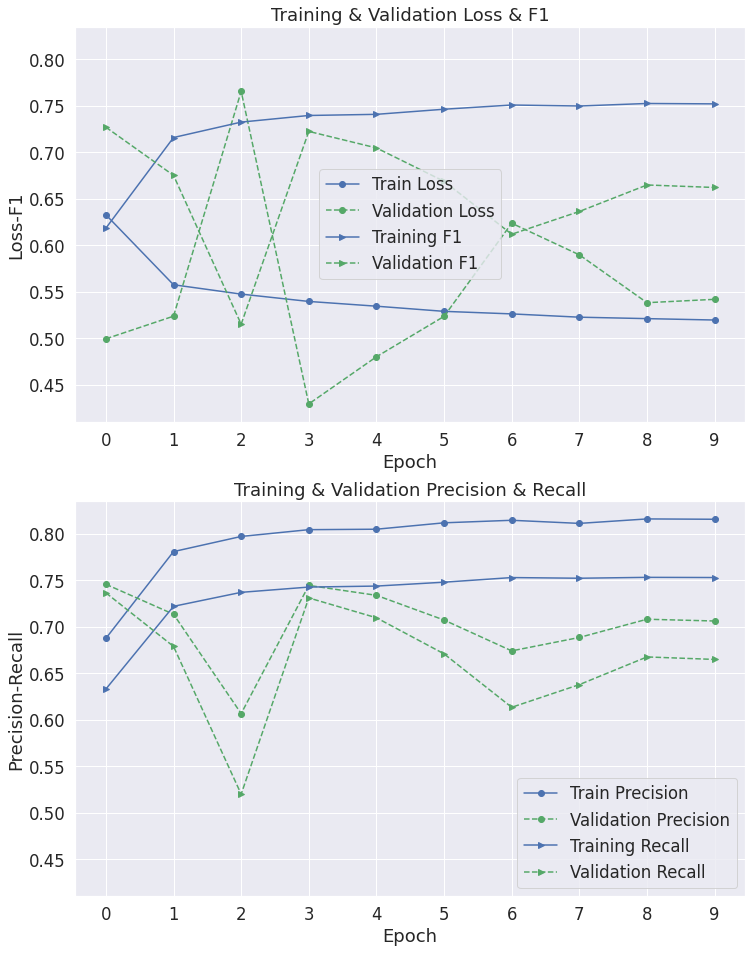

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
  
fig, (ax1, ax2) = plt.subplots(nrows=2, sharey=True, figsize=(12, 16))

# Plot the learning curve.
ax1.plot(res_df['train_loss'], 'b-o', label="Train Loss")
ax1.plot(res_df['valid_loss'], 'g--o', label="Validation Loss")

ax1.plot(res_df['train_f1'], 'b->', label="Training F1")
ax1.plot(res_df['valid_f1'], 'g-->', label="Validation F1")

ax2.plot(res_df['train_precision'], 'b-o', label="Train Precision")
ax2.plot(res_df['valid_precision'], 'g--o', label="Validation Precision")

ax2.plot(res_df['train_recall'], 'b->', label="Training Recall")
ax2.plot(res_df['valid_recall'], 'g-->', label="Validation Recall")

# Label the plot.
ax1.title.set_text("Training & Validation Loss & F1")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss-F1")
ax1.legend()
ax1.set_xticks(res_df['Epoch']-1)

ax2.title.set_text("Training & Validation Precision & Recall")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Precision-Recall")
ax2.legend()
ax2.set_xticks(res_df['Epoch']-1)

plt.show()

## Evaluation on Test Set


In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          path=None,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Parameters
    ----------
    cm: Confusion matrix provided by sklearn

    classes: list of class labels

    normalize: 'True' to normalize confusion matrix. "False" by default.

    path: String that contains the path to save the confusion matrix image

    title: title of the plot

    cmap: A matplotlib color map for the confusion matrix
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(9,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=14)

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)

    print("Saving image..")
    plt.savefig(path)
    print("Image saved at:", path)

    plt.show()

def xlnet_predict(model, test_df, path):
    """Perform a forward pass on the trained XLNet model to predict probabilities
    on the test set.

    Parameters
    ----------
    model: best model from training/validation step

    test_df: Dataframe for the test set being used

    path: Path for the confusion to be saved used by `plot_confusion_matrix()`

    """
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    all_labels = []
    all_predictions = []

    # Put the model into the evaluation mode. The dropout layers are disabled during the test time.
    model.eval()

    test_loader = DataLoader(test_df, batch_size = 8)

    for iter, (inputs, attns, labels) in enumerate(notebook.tqdm(test_loader, desc="Testing")):
        # putting inputs to device
        inputs = inputs.to(DEVICE)
        attns = attns.to(DEVICE)
        labels = labels.to(DEVICE)

        # feed to model
        with torch.no_grad():
            outputs = model(inputs,
                          token_type_ids=None, 
                          attention_mask=attns)
            logits = outputs[0]

            predictions = torch.argmax(logits, dim=-1)
            all_predictions += predictions.cpu().flatten().tolist()
            all_labels += labels.cpu().flatten().tolist()
            

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
    conf_mat = confusion_matrix(all_labels, all_predictions)
    print("F1-score:", "%.2f%%" % (f1*100), "\n",
          "\nPrecision:", "%.2f%%" % (precision*100),
          "\nPrecision (CSAT=1): ", "%.2f%%" % (conf_mat[1][1] / (conf_mat[1][1] + conf_mat[0][1]) * 100),
          "\nPrecision (CSAT=0): ", "%.2f%%" % (conf_mat[0][0] / (conf_mat[0][0] + conf_mat[1][0]) * 100), "\n", 
          "\nRecall:", "%.2f%%" % (recall*100),
          "\nRecall (CSAT=1): ", "%.2f%%" % (conf_mat[1][1] / (conf_mat[1][1] + conf_mat[1][0]) * 100),
          "\nRecall (CSAT=0): ", "%.2f%%" % (conf_mat[0][0] / (conf_mat[0][0] + conf_mat[0][1]) * 100), "\n"
    )
    plot_confusion_matrix(conf_mat, ["0","1"],path=path)

In [ ]:
torch.cuda.empty_cache()


F1-score: 69.14% 
 
Precision: 66.65% 
Precision (CSAT=1):  94.67% 
Precision (CSAT=0):  38.63% 
 
Recall: 76.05% 
Recall (CSAT=1):  83.91% 
Recall (CSAT=0):  68.18% 

Confusion matrix, without normalization
Saving image..
Image saved at: /content/gdrive/My Drive/csatBERT/Experiment3/XLNet_768_v1/


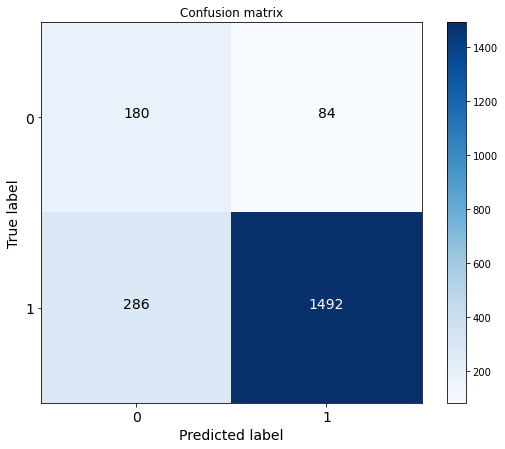

In [20]:
saved_conf_mat_path = "/content/gdrive/My Drive/csatBERT/Experiment3/XLNet_768_v1/"
saved_model_path= "/content/gdrive/My Drive/csatBERT/Experiment3/XLNet_768_v1/saved_model_epoch_3"
test_model = XLNetForSequenceClassification.from_pretrained(saved_model_path).to('cuda')
xlnet_predict(test_model, test_df, saved_conf_mat_path)


F1-score: 68.46% 
 
Precision: 66.08% 
Precision (CSAT=1):  94.68% 
Precision (CSAT=0):  37.47% 
 
Recall: 75.79% 
Recall (CSAT=1):  83.01% 
Recall (CSAT=0):  68.56% 

Confusion matrix, without normalization
Saving image..
Image saved at: /content/gdrive/My Drive/csatBERT/Experiment3/XLNet_768_v1/


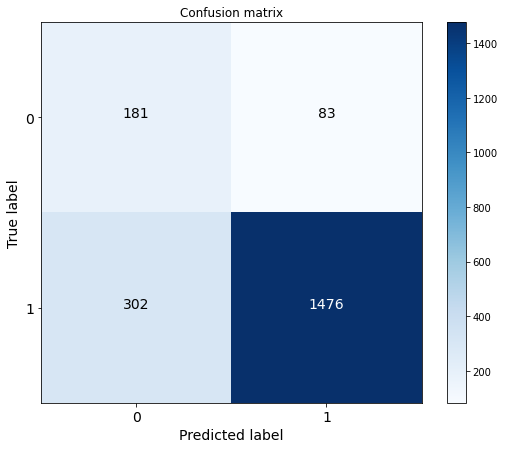

In [22]:
saved_conf_mat_path = "/content/gdrive/My Drive/csatBERT/Experiment3/XLNet_768_v1/"
saved_model_path= "/content/gdrive/My Drive/csatBERT/Experiment3/XLNet_768_v1/saved_model_epoch_6"
test_model = XLNetForSequenceClassification.from_pretrained(saved_model_path).to('cuda')
xlnet_predict(test_model, test_df, saved_conf_mat_path)

In [23]:
def get_csat_ci(model, 
                test_df, 
                experiment_path = '/content/gdrive/My Drive/csatBERT/Experiment3/XLNet_768_v1/',
                file_name = 'pred_lab.csv'):
  
    """Similar to xlnet_predict(). This function calculates evaluates the model on a given test set and saves the predictions and labels into a csv .

    Parameters
    ----------
    model: best model from training/validation step

    test_df: Dataframe for the test set being used

    experiment_path: Path where the desired model is stored

    file_name: Name of the csv file being saved.

    """
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    all_labels = []
    all_predictions = []

    # Put the model into the evaluation mode. The dropout layers are disabled during the test time.
    model.eval()

    test_loader = DataLoader(test_df, batch_size = 50)

    with open(experiment_path + file_name, 'w') as csvfile:
      fieldnames = ['predictions', 'labels']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',')
      writer.writeheader()

      for iter, (inputs, attns, labels) in enumerate(notebook.tqdm(test_loader, desc="Testing")):
          # putting inputs to device
          inputs = inputs.to(DEVICE)
          attns = attns.to(DEVICE)
          labels = labels.to(DEVICE)

          # feed to model
          with torch.no_grad():
              outputs = model(inputs,
                            token_type_ids=None, 
                            attention_mask=attns)
              logits = outputs[0]

              predictions = torch.argmax(logits, dim=-1)
              all_predictions += predictions.cpu().flatten().tolist()
              all_labels += labels.cpu().flatten().tolist()

              for i in range(len(predictions.cpu().flatten().tolist())):
                writer.writerow({'predictions': predictions.cpu().flatten().tolist()[i], 'labels': labels.cpu().flatten().tolist()[i]})

      precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
      conf_mat = confusion_matrix(all_labels, all_predictions)
      print("F1-score:", "%.2f%%" % (f1*100), "\n",
            "\nPrecision:", "%.2f%%" % (precision*100),
            "\nPrecision (CSAT=1): ", "%.2f%%" % (conf_mat[1][1] / (conf_mat[1][1] + conf_mat[0][1]) * 100),
            "\nPrecision (CSAT=0): ", "%.2f%%" % (conf_mat[0][0] / (conf_mat[0][0] + conf_mat[1][0]) * 100), "\n", 
            "\nRecall:", "%.2f%%" % (recall*100),
            "\nRecall (CSAT=1): ", "%.2f%%" % (conf_mat[1][1] / (conf_mat[1][1] + conf_mat[1][0]) * 100),
            "\nRecall (CSAT=0): ", "%.2f%%" % (conf_mat[0][0] / (conf_mat[0][0] + conf_mat[0][1]) * 100), "\n"
      )

In [24]:
saved_model_path= "/content/gdrive/My Drive/csatBERT/Experiment3/XLNet_768_v1/saved_model_epoch_3"
test_model = XLNetForSequenceClassification.from_pretrained(saved_model_path).to('cuda')

In [25]:
torch.cuda.empty_cache()
!nvidia-smi

Fri Aug 14 16:00:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    38W / 250W |   1381MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [26]:
get_csat_ci(test_model, test_df)


F1-score: 69.14% 
 
Precision: 66.65% 
Precision (CSAT=1):  94.67% 
Precision (CSAT=0):  38.63% 
 
Recall: 76.05% 
Recall (CSAT=1):  83.91% 
Recall (CSAT=0):  68.18% 



In [27]:
drive.mount('/content/gdrive')
pred_lab_path = "/content/gdrive/My Drive/csatBERT/Experiment3/XLNet_768_v1/pred_lab.csv"
ci_df= pd.read_csv(pred_lab_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
iterations = 100000
lowerbounds_95 = []
upperbounds_95 = []
mean_pred = []
mean_lab = []

for itn in range(iterations):
  #get 100 random indices
  idx = np.random.choice(len(ci_df), size=100, replace=True)
  resampled_df = ci_df.iloc[idx]
  mean_pred.append(np.mean(resampled_df.predictions))

  mean_label = np.mean(resampled_df.labels)
  mean_lab.append(mean_label)
  std_error = np.std(resampled_df.labels) / np.sqrt(len(resampled_df))
  lower_bound_95 = mean_label - 1.96*std_error
  upper_bound_95 = mean_label + 1.96*std_error
  lowerbounds_95.append(lower_bound_95)
  upperbounds_95.append(upper_bound_95)

d = {'mean_predictions': mean_pred, 'mean_labels':mean_lab, 'lower_bound':lowerbounds_95, 'upper_bound':upperbounds_95}
df1 = pd.DataFrame(d, columns = ["mean_predictions", "mean_labels", "lower_bound", "upper_bound"])
df1["within_range"] = df1.mean_predictions.between(df1.lower_bound, df1.upper_bound)
df1["above"] = df1.mean_predictions.gt(df1.mean_labels)
df1["equal"] = df1.mean_predictions.eq(df1.mean_labels)
df1["lower"] = df1.mean_predictions.lt(df1.mean_labels)

In [29]:
df1.head()

,mean_predictions,mean_labels,lower_bound,upper_bound,within_range,above,equal,lower
0,0.77,0.82,0.744699,0.895301,True,False,False,True
1,0.83,0.91,0.853908,0.966092,False,False,False,True
2,0.69,0.82,0.744699,0.895301,False,False,False,True
3,0.76,0.91,0.853908,0.966092,False,False,False,True
4,0.84,0.92,0.866827,0.973173,False,False,False,True


In [30]:
print("Equal:",df1.equal.value_counts()[1])
print("Higher:",df1.above.value_counts()[1])
print("Lower:",df1.lower.value_counts()[1])
print("% of predictions that are HIGHER than true mean:",  "%.2f%%" %(df1.above.value_counts()[1] / (df1.above.value_counts()[1] + df1.lower.value_counts()[1] + df1.equal.value_counts()[1])*100))
print("% of predictions that are LOWER than true mean:",  "%.2f%%" %(df1.lower.value_counts()[1] / (df1.above.value_counts()[1] + df1.lower.value_counts()[1] + df1.equal.value_counts()[1])*100))

Equal: 542
Higher: 520
Lower: 98938
% of predictions that are HIGHER than true mean: 0.52%
% of predictions that are LOWER than true mean: 98.94%


In [31]:
val = df1.within_range.value_counts()[1] / (df1.within_range.value_counts()[0] + df1.within_range.value_counts()[1])*100
print("For {0:.2f}% of the 100-sample test set, the predicted mean is within the 95% confidence interval of the true CSAT mean ".format(val)) 

For 22.21% of the 100-sample test set, the predicted mean is within the 95% confidence interval of the true CSAT mean 


In [ ]:
from sklearn.utils import resample

In [ ]:
iterations = 2000
boot = []
for itn in range(iterations):
  #for each bootstrap iteration, get a bootstrap sample via resampling with replacements.
  resampled_df = resample(ci_df.labels)
  boot.append(np.mean(resampled_df))

mean_std = np.std(boot)
lower_bound_95 = np.mean(boot) - 1.96*(mean_std)
upper_bound_95 = np.mean(boot) + 1.96*(mean_std)
lower_bound_99 = np.mean(boot) - 2.576*(mean_std)
upper_bound_99 = np.mean(boot) + 2.576*(mean_std)
print("Mean of Predictons:", np.mean(ci_df.predictions))
print("95% Confidence Interval of True Labels:", lower_bound_95, upper_bound_95)
print("99% Confidence Interval of True Labels:", lower_bound_99, upper_bound_99)

Mean of Predictons: 0.8344612181155648
95% Confidence Interval of True Labels: 0.8337203015697231 0.8660839670403754
99% Confidence Interval of True Labels: 0.8286345827100492 0.8711696859000493
